In [1]:
import numpy as np
import scipy.io
import pandas as pd
import json
from typing import List, Tuple, Callable
import run_classifiers

corrs_location = '../corrs'
A_mats_location = '../A_mats'

participants = pd.read_table('../SRPBS_OPEN/participants.tsv')
participants = participants.dropna()

train_sites = ['COI','KUT','SWA','UTO']
test_sites = ['ATT','ATT','CIN','HKH','HRC','HUH','KTT']

In [2]:
def participant_id_to_number(participant_id: str) -> int:
    return int(participant_id.split('-')[1])

def extract_participants_ids(participants: pd.DataFrame, ids: List[int]) -> pd.DataFrame:
	return participants[[participant_id_to_number(name) in ids for name in participants.participant_id.to_numpy()]]

def unpair(pairs: List[List[int]]) -> List[int]:
	return [id for pair in pairs for id in pair]

* 2 types of data (A matrices or correlations)
* 2 outlier choices (remove or not)
* 3 dataset subsets (all data, all pairs, perfect pairs)

In total - we have 2x2x3 = 12 datasets to feed into the classifiers

In [3]:
with open('../Dataset Analysis/dataset_all.txt','r') as f:
	ids_all_all = json.loads(f.read())
with open('../Dataset Analysis/dataset_inliers.txt','r') as f:
	ids_inliers_all = json.loads(f.read())
with open('../Dataset Analysis/all_pairs.txt','r') as f:
	ids_all_pairs = json.loads(f.read())
with open('../Dataset Analysis/all_inliers_pairs.txt','r') as f:
	ids_inliers_pairs = json.loads(f.read())
with open('../Dataset Analysis/all_perfect_pairs.txt','r') as f:
	ids_all_perfectpairs = json.loads(f.read())
with open('../Dataset Analysis/all_inliers_perfect_pairs.txt','r') as f:
	ids_inliers_perfectpairs = json.loads(f.read())

dataset_types = {
	'all': {'all': ids_all_all, 'inliers': ids_inliers_all}, 
	'pairs': {'all': ids_all_pairs, 'inliers': ids_inliers_pairs, 'all_perfect': ids_all_perfectpairs, 'inliers_perfect': ids_inliers_perfectpairs}}

In [4]:
def read_correlation(subject: int) -> np.ndarray:
	return np.nan_to_num(scipy.io.loadmat(f'{corrs_location}/correlation_components_{subject:04d}.mat')['corr_components'])

def read_A_matrix(subject: int) -> np.ndarray:
	return np.nan_to_num(scipy.io.loadmat(f'{A_mats_location}/dcm_A_{subject:04d}.mat')['A'])

load_data_functions = {'corr': read_correlation, 'A_mat': read_A_matrix}

In [5]:
def load_dataset(ids: List[int], load_data_function: Callable[[int], np.ndarray]) -> Tuple[np.ndarray,np.ndarray,np.ndarray,np.ndarray]:
	data = np.array([load_data_function(id) for id in ids])
	particpant_data = extract_participants_ids(participants, ids)
	particpants_train = [participant in train_sites for participant in particpant_data.site.to_numpy()]
	particpants_test = [participant in test_sites for participant in particpant_data.site.to_numpy()]

	X_train = data[particpants_train].reshape((np.count_nonzero(particpants_train), -1))
	X_test = data[particpants_test].reshape((np.count_nonzero(particpants_test), -1))
	Y_train = particpant_data[particpants_train].diag.to_numpy() / 2
	Y_test = particpant_data[particpants_test].diag.to_numpy() / 2
	return X_train, X_test, Y_train, Y_test

def load_dataset_pairs(ids: List[List[int]], load_data_function: Callable[[int], np.ndarray]) -> Tuple[np.ndarray,np.ndarray,np.ndarray,np.ndarray]:
	data = np.array([[load_data_function(id) for id in pair] for pair in ids])
	particpant_data = [extract_participants_ids(participants, pair) for pair in ids]
	sites = [pair.iloc[0].site for pair in particpant_data]
	particpants_train = [site in train_sites for site in sites]
	particpants_test = [site in test_sites for site in sites]

	X_train = data[particpants_train].reshape((-1,*data.shape[2:3])).reshape((2*np.count_nonzero(particpants_train), -1))
	X_test = data[particpants_test].reshape((-1,*data.shape[2:3])).reshape((2*np.count_nonzero(particpants_test), -1))
	Y_train = np.array([0,1] * (X_train.shape[0]//2))
	Y_test = np.array([0,1] * (X_test.shape[0]//2))
	return X_train, X_test, Y_train, Y_test

In [6]:
datasets = []

for function_name, load_data_function in load_data_functions.items():
	for dataset_name, ids in dataset_types['all'].items():
		datasets.append([f'{dataset_name}_all_{function_name}', *load_dataset(ids, load_data_function)])
	for dataset_name, ids in dataset_types['pairs'].items():
		datasets.append([f'{dataset_name}_pairs_{function_name}', *load_dataset_pairs(ids, load_data_function)])

In [7]:
for dataset in datasets:
	train_proportion = 100*dataset[3].shape[0]/(dataset[3].shape[0] + dataset[4].shape[0])
	test_proportion = 100*dataset[4].shape[0]/(dataset[3].shape[0] + dataset[4].shape[0])
	print(f'{dataset[0]}: \n\ttrain - [X: {dataset[1].shape}, Y: {dataset[3].shape}] ({train_proportion:.1f}%)\n\ttest -  [X: {dataset[2].shape}, Y: {dataset[4].shape}] ({test_proportion:.1f}%)')

all_all_corr: 
	train - [X: (626, 70876), Y: (626,)] (62.4%)
	test -  [X: (378, 70876), Y: (378,)] (37.6%)
inliers_all_corr: 
	train - [X: (589, 70876), Y: (589,)] (61.7%)
	test -  [X: (366, 70876), Y: (366,)] (38.3%)
all_pairs_corr: 
	train - [X: (292, 70876), Y: (292,)] (58.9%)
	test -  [X: (204, 70876), Y: (204,)] (41.1%)
inliers_pairs_corr: 
	train - [X: (270, 70876), Y: (270,)] (57.9%)
	test -  [X: (196, 70876), Y: (196,)] (42.1%)
all_perfect_pairs_corr: 
	train - [X: (140, 70876), Y: (140,)] (72.2%)
	test -  [X: (54, 70876), Y: (54,)] (27.8%)
inliers_perfect_pairs_corr: 
	train - [X: (120, 70876), Y: (120,)] (69.8%)
	test -  [X: (52, 70876), Y: (52,)] (30.2%)
all_all_A_mat: 
	train - [X: (626, 142129), Y: (626,)] (62.4%)
	test -  [X: (378, 142129), Y: (378,)] (37.6%)
inliers_all_A_mat: 
	train - [X: (589, 142129), Y: (589,)] (61.7%)
	test -  [X: (366, 142129), Y: (366,)] (38.3%)
all_pairs_A_mat: 
	train - [X: (292, 142129), Y: (292,)] (58.9%)
	test -  [X: (204, 142129), Y: (204,)

In [8]:
scores = run_classifiers.run_classifiers(datasets)

Processing Logistic Regression classifier...
... for all_all_corr classifier


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


... for inliers_all_corr classifier


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


... for all_pairs_corr classifier


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


... for inliers_pairs_corr classifier


C:\ProgramData\Miniconda3\envs\translational\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


... for all_perfect_pairs_corr classifier
... for inliers_perfect_pairs_corr classifier
... for all_all_A_mat classifier
... for inliers_all_A_mat classifier
... for all_pairs_A_mat classifier
... for inliers_pairs_A_mat classifier
... for all_perfect_pairs_A_mat classifier
... for inliers_perfect_pairs_A_mat classifier
Processing Lasso classifier...
... for all_all_corr classifier
... for inliers_all_corr classifier
... for all_pairs_corr classifier
... for inliers_pairs_corr classifier
... for all_perfect_pairs_corr classifier
... for inliers_perfect_pairs_corr classifier
... for all_all_A_mat classifier
... for inliers_all_A_mat classifier
... for all_pairs_A_mat classifier
... for inliers_pairs_A_mat classifier
... for all_perfect_pairs_A_mat classifier
... for inliers_perfect_pairs_A_mat classifier
Processing Random Forest classifier...
... for all_all_corr classifier
... for inliers_all_corr classifier
... for all_pairs_corr classifier
... for inliers_pairs_corr classifier
... fo

In [11]:
scores_df = pd.DataFrame(scores)
scores_df

,Logistic Regression,Lasso,Random Forest,AdaBoost
all_all_corr,0.835410,0.860651,0.839839,0.823463
inliers_all_corr,0.838763,0.860617,0.841083,0.817853
all_pairs_corr,0.806832,0.849219,0.795658,0.807986
inliers_pairs_corr,0.802930,0.849214,0.792641,0.799441
all_perfect_pairs_corr,0.775625,0.848522,0.779397,0.775625
inliers_perfect_pairs_corr,0.808699,0.848390,0.804197,0.771351
all_all_A_mat,0.840590,0.847630,0.840590,0.826200
inliers_all_A_mat,0.841083,0.847313,0.841083,0.823374
all_pairs_A_mat,0.801166,0.845107,0.783006,0.792422
inliers_pairs_A_mat,0.805290,0.845107,0.778622,0.789323


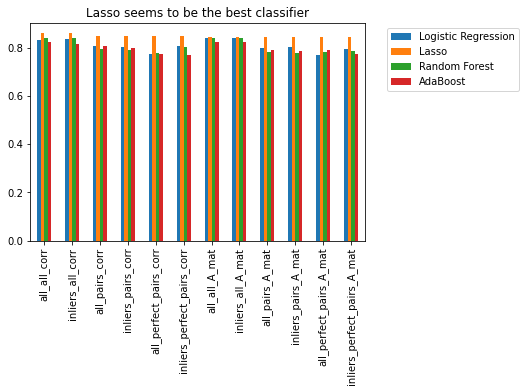

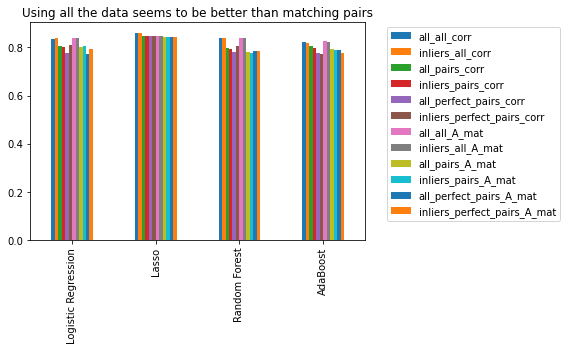

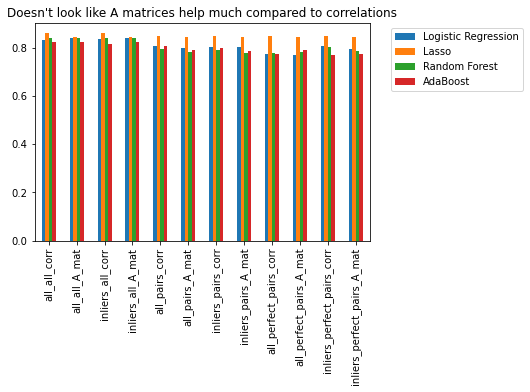

In [32]:
import matplotlib.pyplot as plt

scores_df.plot(kind='bar')
plt.title('Lasso seems to be the best classifier')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

scores_df.T.plot(kind='bar')
plt.title('Using all the data seems to be better than matching pairs')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

scores_df.loc[['all_all_corr','all_all_A_mat','inliers_all_corr','inliers_all_A_mat','all_pairs_corr','all_pairs_A_mat','inliers_pairs_corr','inliers_pairs_A_mat','all_perfect_pairs_corr','all_perfect_pairs_A_mat','inliers_perfect_pairs_corr','inliers_perfect_pairs_A_mat']].plot(kind='bar')
plt.title('Doesn\'t look like A matrices help much compared to correlations')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

In [33]:
np.save('classifier_scores', scores)
np.save('classifier_scores_df', scores_df)